In [8]:
import torch
import torchvision 
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import pandas as pd
import pydicom
import numpy as np
import os

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
# Constants
in_channel = 3  # RGB images after converting DICOM to RGB
num_classes = 1  # Binary classification (cancerous or non-cancerous)
batch_size = 16  # Adjust depending on memory
image_size = 300  # Resize image to this size (300x300)
learning_rate = 0.001  # Initial learning rate
num_epochs = 20  # Adjust depending on your requirement

# Load the CSV file with image paths and labels
csv_file = 'RSNA_breast_cancer_data.csv'  # Update this to your CSV file path
data_df = pd.read_csv(csv_file)
data_df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,implant,machine_id,difficult_negative_case,image_path
0,1,1014,629904228,L,MLO,76.0,0,0,0,0,49,False,IMG\629904228.dcm
1,1,1014,669597068,L,CC,76.0,0,0,0,0,49,False,IMG\669597068.dcm
2,1,1014,229558076,R,MLO,76.0,0,0,0,0,49,False,IMG\229558076.dcm
3,1,1014,1173679750,R,CC,76.0,0,0,0,0,49,False,IMG\1173679750.dcm
4,1,10208,638273415,L,MLO,56.0,0,0,0,0,49,True,IMG\638273415.dcm


In [23]:
# Define the dataset class for loading mammograms from DICOM files
import numpy as np
import pydicom
import torch
import os

class BreastCancerDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __getitem__(self, index):
        # Get image path and label from the dataframe
        row = self.dataframe.iloc[index]
        img_path = os.path.join(self.root_dir, row['image_path'])
        
        # Read the DICOM image
        dicom_img = pydicom.dcmread(img_path).pixel_array
        
        # Ensure the image is in float32 format for further processing
        dicom_img = dicom_img.astype(np.float32)
        
        # Normalize the image to [0, 1]
        dicom_img = (dicom_img - dicom_img.min()) / (dicom_img.max() - dicom_img.min())
        
        # Convert to 3-channel if the image is grayscale (2D)
        if len(dicom_img.shape) == 2:  # If the image is grayscale (2D)
            dicom_img = np.stack([dicom_img] * 3, axis=-1)  # Convert to 3 channels
        
        # Convert the numpy array to a PyTorch tensor and change the order to (C, H, W)
        dicom_img = torch.tensor(dicom_img).permute(2, 0, 1).float()  # (C, H, W)
        
        # Get the cancer label (0 = non-cancerous, 1 = cancerous)
        label = torch.tensor([row['cancer']]).float()

        # Apply transformations if available
        if self.transform:
            dicom_img = self.transform(dicom_img)

        return dicom_img, label


In [24]:
# Image transformations (preprocessing)
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),  # Resize images to 300x300
    transforms.ToTensor(),  # Convert image to PyTorch Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize with ImageNet stats
])

In [25]:
# Load dataset
root_dir = 'IMG'  # Directory where DICOM images are stored
dataset = BreastCancerDataset(dataframe=data_df, root_dir=root_dir, transform=transform)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

TypeError: object of type 'BreastCancerDataset' has no len()

In [26]:
# Load the pre-trained ResNeXt50 model
model = torchvision.models.resnext50_32x4d(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)  # Modify final layer for binary classification
model = model.to(device)  # Move the model to the GPU

# Define loss function (Binary Cross Entropy) and optimizer
criterion = nn.BCEWithLogitsLoss()  # This is suitable for binary classification
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

c:\Users\abhil.LAPTOP-UDIMD39P\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\abhil.LAPTOP-UDIMD39P\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [27]:
# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    for imgs, labels in data_loader:
        imgs = imgs.to(device)  # Move images to GPU
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(imgs).squeeze(1)  # Get model predictions
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(data_loader):.4f}")

print("Training complete!")

TypeError: Cannot handle this data type: (1, 1, 3), <u2

In [ ]:
# Save the model for future use
torch.save(model.state_dict(), 'breast_cancer_detection_model.pth')

# Evaluation (Optional, add test dataset here)
def evaluate(model, data_loader):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in data_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs).squeeze(1)
            predictions = torch.sigmoid(outputs) > 0.5  # Apply sigmoid and threshold at 0.5
            total += labels.size(0)
            correct += (predictions == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Accuracy: {accuracy:.2f}%")

# Call the evaluate function with the test set
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# evaluate(model, test_loader)


=====================================================================================================================================================

In [ ]:
from torchvision.models import ResNeXt50_32X4D_Weights,ResNeXt101_64X4D_Weights, ResNeXt101_32X8D_Weights
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, random_split
from torchsummary import summary
from PIL import Image
import os
import cv2
import numpy as np

In [ ]:
in_channel = 3
num_classes = 1
batch_size = 32

In [ ]:
#loading comofod dataset
size = 232


class comofod(Dataset):
    def _init_(self, root_dir):
        self.root_dir = root_dir
        self.transform = transforms.Compose([
            transforms.Resize(232, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        self.img_names = [file_name for file_name in os.listdir(root_dir) if file_name.endswith(('.jpg','.png'))]
    
    def _len_(self):
        return len(self.img_names)
    
    def _getitem_(self, index):
        img_name = os.path.join(self.root_dir, self.img_names[index])
        img = Image.open(img_name).convert("RGB")
        label = 1 if 'F' in img_name else 0
        label = torch.tensor([label]).float()

        
        if self.transform:
            img = self.transform(img)
        
        return img, label
    




dataset = comofod(root_dir='/kaggle/input/comofod-full/comofod_full')

comofod_loader = DataLoader(dataset, batch_size=batch_size, shuffle= True) # only getting the 4000 imagas
print(len(comofod_loader))


In [ ]:
import matplotlib.pyplot as plt
from collections import Counter



# Get one batch of images and labels
images, labels = next(iter(comofod_loader))

# Function to plot a grid of images
def plot_images(images, labels):
    fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].numpy().transpose(1, 2, 0))
        ax.set_title(f"Label: {int(labels[i].item())}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Plot a grid of images
plot_images(images, labels)

# Convert labels to a 1D NumPy array
labels_np = labels.numpy().flatten()

# Count the number of images and labels per class
class_counts = Counter(labels_np)
print(class_counts)

In [ ]:
model = torchvision.models.resnext101_64x4d(weights=ResNeXt101_64X4D_Weights.DEFAULT) #importing the resnext101 model

print(torch.cuda.device_count())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("The device is : ", device)

model.eval() # Set the model to evaluation mode 
model.to(device) # Move the model to the GPU # Remove the last fully connected layer 
feature_extractor = nn.Sequential(*(list(model.children())[:-1])) 
feature_extractor.to(device) # Move the feature extractor to the GPU # Function to extract features 
def extract_features(dataloader): 
    features = [] 
    labels = [] 
    with torch.no_grad(): 
        for imgs, lbls in dataloader: 
            imgs = imgs.to(device) # Move images to the GPU 
            output = feature_extractor(imgs) 
            features.append(output.flatten(start_dim=1).cpu().numpy()) # Move features back to the CPU 
            labels.append(lbls.numpy()) 
    return np.concatenate(features), np.concatenate(labels)


#this function is used as feature extractor for all the images inside different datasets

----------------------------------------------------------------------------------

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import models, transforms
import numpy as np
import pydicom
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load the CSV file
df = pd.read_csv('RSNA_breast_cancer_data.csv')  # Adjust the path as needed

In [19]:
# Function to load DICOM images and resize them
def load_dicom_image(image_path, target_size=(224, 224)):  # Resize to 224x224 for ResNeXt50
    dicom = pydicom.dcmread(image_path)
    image = dicom.pixel_array
    image_resized = cv2.resize(image, target_size)
    image_normalized = image_resized / np.max(image_resized)  # Normalize pixel values
    
    # Convert grayscale to 3 channels by replicating the grayscale image
    image_rgb = np.stack([image_normalized] * 3, axis=-1)  # Replicate across 3 channels
    return image_rgb

# Load all the images and labels
image_paths = df['image_path'].values
labels = df['cancer'].values

# Prepare data
images = []
for path in image_paths:
    image = load_dicom_image(path)  # Directly use the full path from the CSV
    images.append(image)

images = np.array(images)
labels = np.array(labels)

In [39]:
images.shape

torch.Size([32, 224, 224, 3])

In [41]:
# Correcting the permutation of dimensions:
images = images.permute(0, 3, 1, 2)

In [42]:
images.shape

torch.Size([32, 3, 224, 224])

In [43]:
# Train-test split
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [44]:
# Convert to tensors and apply transformations
train_images = torch.tensor(X_train, dtype=torch.float32)
val_images = torch.tensor(X_val, dtype=torch.float32)
test_images = torch.tensor(X_test, dtype=torch.float32)

train_labels = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # Make labels 2D
val_labels = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
test_labels = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Create TensorDataset for train, val, test
train_dataset = TensorDataset(train_images, train_labels)
val_dataset = TensorDataset(val_images, val_labels)
test_dataset = TensorDataset(test_images, test_labels)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

C:\Users\abhil.LAPTOP-UDIMD39P\AppData\Local\Temp\ipykernel_15772\361010318.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_images = torch.tensor(X_train, dtype=torch.float32)
C:\Users\abhil.LAPTOP-UDIMD39P\AppData\Local\Temp\ipykernel_15772\361010318.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_images = torch.tensor(X_val, dtype=torch.float32)
C:\Users\abhil.LAPTOP-UDIMD39P\AppData\Local\Temp\ipykernel_15772\361010318.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_images = torch.tensor(X_test, dtype=torch.f

In [45]:
# Initialize the model
model = models.resnext50_32x4d()

# Modify the final layer for binary classification
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 1),
    nn.Sigmoid()
)

c:\Users\abhil.LAPTOP-UDIMD39P\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\abhil.LAPTOP-UDIMD39P\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [50]:
device = torch.device("cpu")


In [49]:
# Loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [46]:
# Training loop
num_epochs = 30
train_losses = []
val_losses = []
train_acc = []
val_acc = []

In [52]:
# Define lists to store training and validation losses/accuracies
train_losses, val_losses = [], []
train_acc, val_acc = [], []

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss, correct_train = 0.0, 0
    total_train = 0
    
    # Training phase
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)

        # Ensure labels have the correct shape
        labels = labels.squeeze(1)  # Remove extra dimension if needed

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        preds = outputs.round()  # Convert outputs to binary predictions (0 or 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)
    
    # Compute average training loss and accuracy for the epoch
    epoch_loss = running_loss / total_train
    epoch_acc = correct_train / total_train
    train_losses.append(epoch_loss)
    train_acc.append(epoch_acc)
    
    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss, correct_val = 0.0, 0
    total_val = 0
    
    with torch.no_grad():  # Disable gradient computation for validation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # Ensure labels have the correct shape
            labels = labels.squeeze(1)

            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            preds = outputs.round()
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)
    
    # Compute average validation loss and accuracy for the epoch
    val_losses.append(val_loss / total_val)
    val_acc.append(correct_val / total_val)
    
    # Print training and validation statistics for this epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Val Loss: {val_loss / total_val:.4f}, '
          f'Accuracy: {epoch_acc:.4f}, Val Accuracy: {correct_val / total_val:.4f}')

Epoch [1/30], Loss: 0.6668, Val Loss: 0.8161, Accuracy: 0.6400, Val Accuracy: 0.3333
Epoch [2/30], Loss: 0.5494, Val Loss: 0.8813, Accuracy: 0.8800, Val Accuracy: 0.3333
Epoch [3/30], Loss: 0.4863, Val Loss: 0.9544, Accuracy: 0.9600, Val Accuracy: 0.3333
Epoch [4/30], Loss: 0.4046, Val Loss: 1.0346, Accuracy: 0.9600, Val Accuracy: 0.3333
Epoch [5/30], Loss: 0.3349, Val Loss: 1.1234, Accuracy: 1.0000, Val Accuracy: 0.3333
Epoch [6/30], Loss: 0.2758, Val Loss: 1.2294, Accuracy: 1.0000, Val Accuracy: 0.3333
Epoch [7/30], Loss: 0.2447, Val Loss: 1.3301, Accuracy: 1.0000, Val Accuracy: 0.3333
Epoch [8/30], Loss: 0.1987, Val Loss: 1.4410, Accuracy: 1.0000, Val Accuracy: 0.3333
Epoch [9/30], Loss: 0.1504, Val Loss: 1.5548, Accuracy: 1.0000, Val Accuracy: 0.3333
Epoch [10/30], Loss: 0.1209, Val Loss: 1.6759, Accuracy: 1.0000, Val Accuracy: 0.3333
Epoch [11/30], Loss: 0.0995, Val Loss: 1.8050, Accuracy: 1.0000, Val Accuracy: 0.3333
Epoch [12/30], Loss: 0.0803, Val Loss: 1.9419, Accuracy: 1.0000

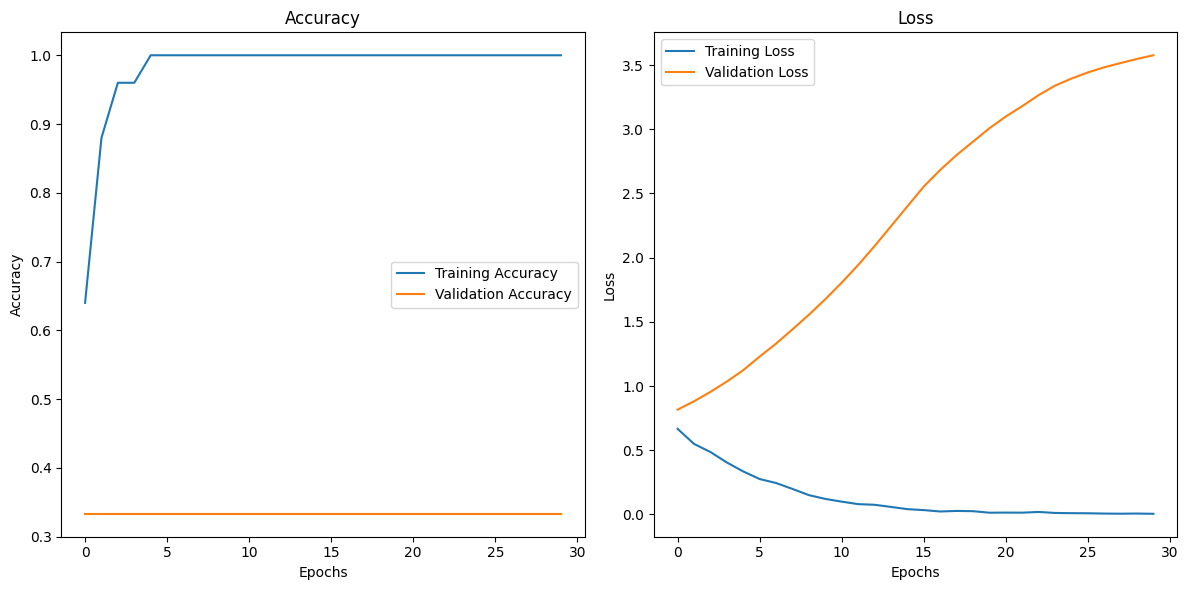

In [53]:
# Plot training and validation loss/accuracy
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [54]:
# Test the model
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.round()

        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_accuracy = correct / total
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 1.0000


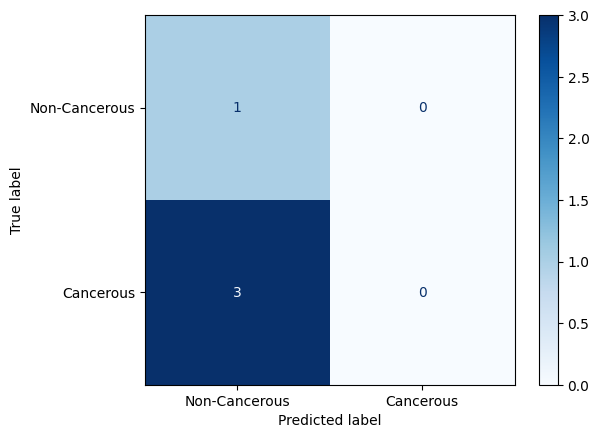

In [56]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming all_labels and all_preds are collected during evaluation
all_labels = np.concatenate(all_labels)
all_preds = np.concatenate(all_preds)

# Convert to binary (0 or 1) if necessary
all_labels = all_labels.astype(int)  # Ensure it's binary (0 or 1)
all_preds = (all_preds > 0.5).astype(int)  # Convert model outputs to 0 or 1

# Now calculate confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Cancerous', 'Cancerous'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [24]:
# Define the ResNeXt50 model
model = models.resnext50_32x4d(pretrained=True)

# Modify the final layer to suit binary classification
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 1),  # Single output for binary classification
    nn.Sigmoid()
)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

c:\Users\abhil.LAPTOP-UDIMD39P\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\abhil.LAPTOP-UDIMD39P\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to C:\Users\abhil.LAPTOP-UDIMD39P/.cache\torch\hub\checkpoints\resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:39<00:00, 2.56MB/s]


In [25]:
# Loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [26]:
# Training function
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=30):
    model.train()
    train_losses, val_losses, train_acc, val_acc = [], [], [], []

    for epoch in range(num_epochs):
        running_loss, correct_train = 0.0, 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            preds = outputs.round()  # Binary predictions
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        epoch_loss = running_loss / total_train
        epoch_acc = correct_train / total_train
        train_losses.append(epoch_loss)
        train_acc.append(epoch_acc)

        # Validation phase
        model.eval()
        val_loss, correct_val = 0.0, 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device).unsqueeze(1)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                preds = outputs.round()
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        val_losses.append(val_loss / total_val)
        val_acc.append(correct_val / total_val)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Val Loss: {val_loss / total_val:.4f}, Accuracy: {epoch_acc:.4f}, Val Accuracy: {correct_val / total_val:.4f}')

    return train_losses, val_losses, train_acc, val_acc

In [29]:
print(images.dtype) 

float64


In [27]:
# Train the model
train_losses, val_losses, train_acc, val_acc = train_model(model, 
                                                           criterion, 
                                                           optimizer, 
                                                           train_loader, 
                                                           val_loader, 
                                                           num_epochs=30)

RuntimeError: expected scalar type Double but found Float

In [ ]:
# Plot accuracy and loss
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Test the model
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).unsqueeze(1)
            outputs = model(images)
            preds = outputs.round()

            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    test_accuracy = correct / total
    print(f'Test Accuracy: {test_accuracy:.4f}')

    # Confusion matrix
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Cancerous', 'Cancerous'])
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

# Evaluate the model on test data
test_model(model, test_loader)